<a href="https://colab.research.google.com/github/clint-bg/demos/blob/main/PaintCanFlamewBuret/PaintCanFlame_w_Buret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paint Can Flame and Bubble Buret
Clint Guymon<br>
BYU Chemical Engineering<br><br>


This is a follow-up to the initial calculation that can be found [here](https://colab.research.google.com/drive/12hMitSzPuh_qgLULOdLjz7xfKmRt7Q31?usp=sharing). A one gallon paint can is filled with a flammable gas (methane) after which air is supplied into the side of the can at different flow rates. 

A video of the setup is [here](https://youtu.be/lmnPmjaJAsw).

![](https://github.com/clint-bg/demos/blob/main/PaintCanFlamewBuret/BubbleBurretwithPaintCanFlame.png?raw=true)

## Transient Material Balances

The change in the internal composition of the can can be estimated from a material balance where:<br>
accumulation = in - out + generation - consumption<br><br>
The above equation can be written for both the flammable component (methane) and the air component inside the can. There isn't any generation or consumption of air or methane inside the can so those terms are zero. The accumulation term is a derivative. In symbolic notation the above equation is: <br>
\begin{align}
dn_f/dt = - \dot{n}^{out}_f, \\
dn_a/dt = \dot{n}^{in}_a - \dot{n}^{out}_a
\end{align} <br>
The dot above the n indicates a rate so that $\dot{n}$ is the change in moles per second from the flow into or out of the can. The derivatives, $dn/dt$, is the change in moles inside the can of the flammable or air component per time. These derivatives are important as they can be integrated numerically to obtain the actual number of moles as a function of time inside the can. With that information, the expected time before the flame is expected to go out or transition inside the can can be estimated. Similarly, the time at which a flammable concentration is reached inside the can can be determined. <br><br>

There is a constant flow of aid into the can as measured by the bubble burret. The flow into the can is the same as the outflow as the pressure inside the can is constant.


## Object Oriented Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import param

In [ ]:
class Can(param.Parameterized):
  'Model for filling can with a gas'
  Rg = param.Number(8.314,doc='Gas constant (Jol/mol/K)',constant=True)
  ch4mw = param.Number(0.016,doc='methane molecular weight (kg/mol)',constant=True)
  airmw = param.Number(0.029,doc='air molecular weight (kg/mol)',constant=True)
  Vol = param.Number(0.00379,doc='Volume of 1 gallon in m3 (m3)')
  Patm = param.Number(85000,doc='Atmospheric pressure (Pa)')
  T = param.Number(293,doc='Temperature (K)')
  topholedia = param.Number(0.25*0.0254,doc='Top hole diameter (m)')
  out_mlpersec = 75/3 #ml/s

  #solved for parameters
  t = param.List(np.linspace(0,800,600).tolist()) #list of times to solve for, converted to a list

  def totalmoles(self): #moles of air
    return self.Patm*self.Vol/(self.Rg*self.T)

  def derivs_empty(self,y,t): #derivatives 
    nf,na = y; fracf = nf/(na+nf); flow = self.outlet()[1]
    dnfdt = - flow*fracf
    dnadt = flow - (1-fracf)*flow
    dydt = [dnfdt,dnadt]
    return dydt

  def outlet(self): #outlet flow from the top hole on can due to bouyancy and diffusion 
    #outflow per the measurement with the Burret
    volflow = self.out_mlpersec/1e6 # converted to m3/s
    flow = self.Patm*volflow/(self.Rg*self.T)# PV/RT to convert the volumetric flow to moles per second of air
    vel = volflow/(np.pi/4*self.topholedia**2) #m/s, velocity out the top of the hole
    return [vel,flow]

  def solve(self): #solves for each time step
    self.empty = odeint(self.derivs_empty,[self.totalmoles(),0],self.t)

  def plot(self):
    #solve with the given parameters
    self.solve()
    #set up plot
    fracfe = self.empty[:, 0]/(self.empty[:,1]+self.empty[:,0])
    x = self.t
    upperfl = [0.15 for each in x]; lowerfl = [0.05 for each in x]; outfvel = [self.outlet()[0] for each in x]
    #return plot
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(self.t, fracfe,'r', label='Mole fraction of flammable gas during emptying')
    plt.plot(self.t,outfvel,'b-.', label='Outlet flow velocity (m/s)')
    plt.plot(self.t,[0.3 for each in self.t],'k--',alpha=0.5,label='CH4 flame propagation speed (0.3 m/s)')
    ax.fill_between(x,upperfl,lowerfl,color='r',alpha=0.1,label='flammability limits')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    ax.set_ylim([0, 3.5])
    plt.text(50,0.1,'Flammable zone');plt.text(600,0.31,'CH4 Flame Speed in Air (0.3 m/s)')
    plt.grid() 
    return plt

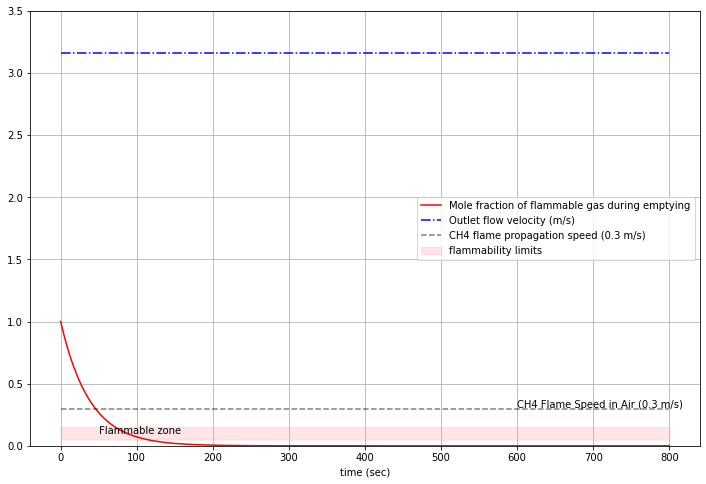

In [ ]:
paintcan = Can()
paintcan.out_mlpersec = 100
paintcan.plot().show()

| Flow   |      Result      | 
|----------|:-------------:|
| 10 mL/s |  <b>explosion</b> with 0.25 in dia hole|
| 25 mL/s |    <b>no explosion</b> with 0.25 in dia hole  |  
|75 mL/s | <b>no explosion</b>  with 0.25 in dia hole|